In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from matplotlib import cm
from scipy import ndimage
from skimage.morphology import watershed
import pickle
from tqdm.auto import tqdm
import copy

In [3]:
MIN = 0
MAX = 2 ** 16 - 1

# import all images per sequence, return images
def import_sequences():
    PATH = '../sequences/0'
    imgs = []
    for i in range(1, 5):
        imgs_path = []
        for image in glob(f'{PATH}{i}/*.tif'):
            img = cv2.imread(image, -1)
            imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
        imgs.append(imgs_path)
    return imgs

NROWS = 700
NCOLS = 1100
NUM_IMAGES = 92


def contrast_stretch(img):
    array = np.array(img)
    min_stretch = 225
    a = 0
    b = 65535
    c = int((min_stretch/255)*65535)
    d = array.max() #max pixel value in img
    img_s = img.copy()
    h, w = img.shape
    img_s[0:h, 0:w] = (img[0:h, 0:w] - c)*((b - a)/(d-c)) + a
    img_s[img<c] = 0
    return img_s


def get_peak(img):
    hist = cv2.calcHist([img],[0],None,[65535],[0,65535])
    #Convert histogram to simple list
    hist = [val[0] for val in hist]; 
    #Generate a list of indices
    indices = list(range(0, 65536));
    #Descending sort-by-key with histogram value as key
    s = [(x,y) for y,x in sorted(zip(hist,indices), reverse=True)]
    #Index of highest peak in histogram
    max_peak = s[0][0];

    i = 1
    while(max_peak < 100):
        max_peak = s[i][0]
        i += 1
    
    return max_peak



def custom_thresh(img):
    peak = get_peak(img)
    hist = cv2.calcHist([img],[0],None,[65537],[0,65537])
    peak_freq = hist[peak]
    curr_freq = peak_freq
    curr = peak
    safteyMargin = 25

    while safteyMargin != 0:
        curr -= 1
        curr_freq = hist[curr]
        ratio = float(curr_freq/peak_freq)

        if(ratio < 0.005):
            safteyMargin -= 1

    ret1, thresh = cv2.threshold(img, curr, 65535, cv2.THRESH_BINARY_INV)

    return thresh




def segment(img):
    # CLAHE preprocess: segment from background

    img_inv = cv2.bitwise_not(img)
    img_s = contrast_stretch(img_inv)
    img_g= cv2.GaussianBlur(img_s,(3,3),1)
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(3,3)) 
    cl1 = clahe.apply(img_g)
    seg = custom_thresh(cl1)

    # clahe = cv2.createCLAHE(clipLimit=80.0, tileGridSize=(25,25))
    # cl1 = clahe.apply(img)

    # hist = cv2.calcHist([cl1],[0],None,[257],[0,MAX])
    # from_max = hist[np.argmax(hist):]
    # for intensity, _ in enumerate(from_max[:-1]):
    #     if from_max[intensity+1] >= from_max[intensity]:
    #         for i in range(30):
    #             if intensity + i >= len(from_max):
    #                 break
    #             if from_max[intensity + i] < intensity - 250:
    #                 break
    #         else:
    #             break

    #final = (intensity + np.argmax(hist)) * 255
    #seg = np.zeros_like(cl1)
    #cv2.threshold(cl1, dst=seg, thresh=final, maxval=MAX, type=cv2.THRESH_BINARY)
    #opens = np.zeros_like(seg)
    elem = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5,5))
    #cv2.morphologyEx(seg, dst=opens, op=cv2.MORPH_OPEN, kernel=elem)

    ero = cv2.erode(seg, kernel=(3,3), iterations=2)
    opens = np.zeros_like(seg)
    cv2.morphologyEx(ero, dst=opens, op=cv2.MORPH_OPEN, kernel=elem, iterations=2)

    #opens = create_img(erode(points(opens)))

    flushed_pts, _ = flush_border_cells(points(opens), opens)

    # watershed: segment cells from each other
    distance = ndimage.distance_transform_edt(opens)
    coords = peak_local_max(distance, footprint=np.ones((5,5)), min_distance = 20, labels = opens)
    mask = np.zeros(distance.shape, dtype = bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    ws_labels = watershed(-distance, markers, mask = opens)
    ws_pts = {}
    for i in range(opens.shape[0]):
        for j in range(opens.shape[1]):
            if ws_labels[i,j] == 0:
                continue
            ws_pts[(i,j)] = ws_labels[i,j]-1

    labels = get_labels(ws_pts)
    new_pts = {}
    for label, cell_pts in labels.items():
        dilated = cell_pts.copy()
        for _ in range(3):
            dilated = dilate(dilated)

        eroded = dilated.copy()
        for _ in range(3):
            eroded = erode(eroded)

        for pt, label in eroded.items():
            new_pts[pt] = label

    # mix local labels
    all_pts = new_pts.copy()
    cents = centroids(new_pts)
    len(cents)
    shuffled = np.arange(0, len(cents))
    np.random.shuffle(shuffled)
    swap_labels = {}
    for i, label in enumerate(cents.values()):
        swap_labels[label] = shuffled[i]
    pts = {}
    for pt, label in all_pts.items():
        pts[pt] = swap_labels[label]
    
    # delete small cells
    labels = get_labels(pts)
    temp_pts = pts.copy()
    del_labels = []
    for label,pts1 in labels.items():
        if len(pts1) < 50:
            del_labels.append(label)
    for pt, label in pts.items():
        if label in del_labels: 
            del temp_pts[pt]

    # adjust flushed points
    temp_flushed_pts = flushed_pts.copy()
    for pt in flushed_pts.keys():
        if pt not in temp_pts:
            del temp_flushed_pts[pt]
        else:
            temp_flushed_pts[pt] = temp_pts[pt]
    return temp_pts, temp_flushed_pts

# show an image inline
def show(img, s=True):
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

# get white points of an image, return dict of coord tuples
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

# flush all cells that touch the border of the image
def flush_border_cells(pts, img):
    to_check = []
    border_pts = {}
    border_img = np.zeros((NROWS, NCOLS))
    for pt in pts:
        if pt[0] == 0 or pt[1] == 0 or pt[0] == NROWS-1 or pt[1] == NCOLS-1:
            to_check.append(pt)
            border_pts[pt] = None
            border_img[pt[0], pt[1]] = MAX
    while len(to_check) > 0:
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
    new = img - border_img
    return points(new), new.astype('uint16')

# create an image from points
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new.astype('uint16')

# binary erosion of points with 3x3 filter
def erode(pts):
    eroded1_pts = {}
    for (x,y) in pts:
        if (x,y-1) in pts and (x, y+1) in pts:
            eroded1_pts[(x,y)] = pts[(x,y)]
    eroded2_pts = {}
    for (x,y) in eroded1_pts:
        if (x-1,y) in eroded1_pts and (x+1, y) in eroded1_pts:
            eroded2_pts[(x,y)] = eroded1_pts[(x,y)]
    return eroded2_pts

# check coords within image bounds
def check_coords(pt):
    if pt[0] < 0 or pt[0] > NROWS-1 or pt[1] < 0 or pt[1] > NCOLS-1:
        return False
    return True

# binary dialtion of points with 3x3 filter
def dilate(pts):
    dilated1_pts = pts.copy()
    for (x,y) in pts:
        if (x,y-1) not in pts and check_coords((x,y-1)):
            dilated1_pts[(x, y-1)] = pts[(x,y)]
        if (x, y+1) not in pts and check_coords((x,y+1)):
            dilated1_pts[(x, y+1)] = pts[(x,y)]
    dilated2_pts = dilated1_pts.copy()
    for (x,y) in dilated1_pts:
        if (x-1,y) not in dilated1_pts and check_coords((x-1,y)):
            dilated2_pts[(x-1, y)] = dilated1_pts[(x,y)]
        if (x+1, y) not in dilated1_pts and check_coords((x+1,y)):  
            dilated2_pts[(x+1, y)] = dilated1_pts[(x,y)]
    return dilated2_pts

# from points and labels create a coloured image
def colour_label_image(pts_labels, show_img=True, max=None):
    cmap = copy.copy(cm.get_cmap('hsv'))
    new_img = np.zeros((NROWS, NCOLS))
    cmap.set_bad(color='black')
    for (pt, label) in pts_labels.items():
        new_img[pt[0],pt[1]] = label
    if max == None:
        norm_new = plt.Normalize(new_img.min(), new_img.max())
    else:
        norm_new = plt.Normalize(new_img.min(), max)
    for i in range(NROWS):
        for j in range(NCOLS):
            if (i,j) not in pts_labels:
                new_img[i,j] = np.nan
    rgba_img = cmap(norm_new(new_img))
    if show_img:
        show(rgba_img)
    return rgba_img, cmap, norm_new

# plot scatter of centroids over the colour labelled image
def plt_rgb_img_scatter(centroids, pts_labels, traj=None, max=None, save=None,
    seq_data=None, num_cells=None, avg_size=None, avg_disp=None, num_div=None,
    og_img=None, splitting=None, alert=None):
    rgb_img, cmap, norm_new = colour_label_image(pts_labels, False, max)
    plt.figure(figsize=(15,15))
    if seq_data != None:
        new = cv2.cvtColor(og_img, cv2.COLOR_GRAY2RGB)
        new = (new * (255/MAX)).astype('uint8')
        for i in range(NROWS):
            for j in range(NCOLS):
                if (i,j) in pts_labels.keys():
                    new[i,j,:] = (rgb_img[i,j,:-1] * 255).astype('uint8')
                elif (i,j) in alert.keys():
                    new[i,j,:] = np.ones((3)) * 255
        plt.imshow(new)
        #plt.imshow(og_img, cmap='gray')
        #plt.imshow(rgb_img, alpha=0.05)
    else:
        plt.imshow(rgb_img)
    if seq_data == None:
        for (x, y) in centroids.keys():
            plt.scatter(y, x, c='white', marker='.')
    '''
    else:
        for (i,j) in splitting:
            plt.scatter(j, i, c='red', marker='o')
    '''
    if traj != None:
        for label, trajectories in traj.items():
            plt.plot(trajectories[1], trajectories[0], c=cmap(norm_new(label)))
    if save != None:
        plt.savefig(save)
    if seq_data != None: 
        plt.title(f'Sequence {seq_data[0]}: frame {seq_data[1]:02d}')
    if num_cells != None:
        plt.text(0,750, f'Cell count: {num_cells:02d}')
        plt.text(250, 750, f'Average cell size: {avg_size}')
        if avg_disp == None:
            plt.text(500,750, 'Average displacement: N/A')
        else:
            plt.text(500,750, f'Average displacement: {avg_disp}')
        plt.text(750,750, f'Currently dividing: {num_div}')
    plt.show()

# get cell contours (outlines) from points
def contours(pts):
    dilated2_pts = dilate(pts)
    sub = {}
    for pt, label in dilated2_pts.items():
        if pt not in pts:
            sub[pt] = label
    return sub

# find average size of cells in the image
def avg_cell_size(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(pts) / len(labels)

# count the number of cells in the image
def cell_count(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(labels)

# use watershed after Chan-Vese to get best results
def watershed_seg(img, min_dist=20):
    distance = ndimage.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((5,5)), min_distance = min_dist, labels = img)
    mask = np.zeros(distance.shape, dtype = bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    ws_labels = watershed(-distance, markers, mask = img)
    ws_pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if ws_labels[i,j] == 0:
                continue
            ws_pts[(i,j)] = ws_labels[i,j]-1
    return ws_pts

# get centroids from points
def centroids(pts):
    labels = {}
    for (x,y), label in pts.items():
        if label not in labels:
            labels[label] = {'x': [x], 'y': [y]}
            continue
        labels[label]['x'].append(x)
        labels[label]['y'].append(y)
    centres = {}
    for label, data in labels.items():
        centres[int(sum(data['x'])/len(data['x'])), 
                int(sum(data['y'])/len(data['y']))] = label
    return centres

def mix_labels(pts):
    all_pts = pts.copy()
    cents = centroids(pts)
    len(cents)
    shuffled = np.arange(0, len(cents))
    np.random.shuffle(shuffled)
    swap_labels = {}
    for i, label in enumerate(cents.values()):
        swap_labels[label] = shuffled[i]
    pts = {}
    for pt, label in all_pts.items():
        pts[pt] = swap_labels[label]
    return pts

def segment_CLAHE(img, show_img=False):
    clahe = cv2.createCLAHE(clipLimit=80.0, tileGridSize=(25,25))
    cl1 = clahe.apply(img)

    hist = cv2.calcHist([cl1],[0],None,[257],[0,MAX])
    from_max = hist[np.argmax(hist):]
    for intensity, num in enumerate(from_max[:-1]):
        if from_max[intensity+1] >= from_max[intensity]:
            for i in range(30):
                if intensity + i >= len(from_max):
                    break
                if from_max[intensity + i] < intensity - 250:
                    break
            else:
                break

    final = (intensity + np.argmax(hist)) * 255
    seg = np.zeros_like(cl1)
    cv2.threshold(cl1, dst=seg, thresh=final, maxval=MAX, type=cv2.THRESH_BINARY)
    opens = np.zeros_like(seg)
    elem = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5,5))
    cv2.morphologyEx(seg, dst=opens, op=cv2.MORPH_OPEN, kernel=elem)
    if show_img:
        show(img)
        show(opens)
        plt.figure(figsize=(15,15))
        plt.hist(cl1.ravel(),255)
        plt.axvline(x=final, color='r')
        plt.show()
    return opens

def delete_small(pts, area=10000):
    labels = get_labels(pts)
    temp_pts = pts.copy()
    del_labels = []
    for label,pts in labels.items():
        if len(pts) < area:
            del_labels.append(label)
    for pt, label in pts.items():
        if label in del_labels: 
            del temp_pts[pt]
    return temp_pts

def segment_img(img):
    thresh = segment_CLAHE(img)
    ws_pts = watershed_seg(thresh, min_dist=17)
    new_pts = seperate_open(ws_pts)
    mixed_pts = mix_labels(new_pts)
    big_pts = delete_small(mixed_pts)
    return big_pts

def get_labels(pts):
    label = {}
    for pt, lbl in pts.items():
        if lbl not in label:
            label[lbl] = {pt: lbl}
        else:
            label[lbl][pt] = lbl
    return label

# close cells in individual vector space so cells are not joined by the operation
def seperate_open(pts, sweeps=3):
    labels = get_labels(pts)
    new_pts = {}
    for label, cell_pts in labels.items():
        dilated = cell_pts.copy()
        for _ in range(sweeps):
            dilated = dilate(dilated)

        eroded = dilated.copy()
        for _ in range(sweeps):
            eroded = erode(eroded)

        for pt, label in eroded.items():
            new_pts[pt] = label
    return new_pts

def dump_obj(obj, filepath):
    with open(filepath, 'wb') as outfile:
        pickle.dump(obj, outfile)

def load_obj(filepath):
    with open(filepath, 'rb') as infile:
        return pickle.load(infile)

def centroid_four(pts):
    pt1 = list(pts.keys())[0]
    extrema = {}
    for pt, label in pts.items():
        if label not in extrema:
            extrema[label] = {'i1': pt[0], 'i2':pt[0], 'j1':pt[1], 'j2':pt[1]}
        else:
            if pt[0] < extrema[label]['i1']:
                extrema[label]['i1'] = pt[0]
            elif pt[0] > extrema[label]['i2']:
                extrema[label]['i2'] = pt[0]
            
            if pt[1] < extrema[label]['j1']:
                extrema[label]['j1'] = pt[1]
            elif pt[1] > extrema[label]['j2']:
                extrema[label]['j2'] = pt[1]
    cents = {}
    for label,vals in extrema.items():
        cents[(vals['i1']+vals['i2'])/2,(vals['j1']+vals['j2'])/2] = label
    return cents

In [4]:
imgs = import_sequences()

In [5]:
seq = {}
flushed_seq = {}
seq[0] = {}
flushed_seq[0] = {}
for i,img in enumerate(imgs[1][:8]):
    seq[0][i], flushed_seq[0][i] = segment(img)

C:\Anaconda\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Anaconda\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Anaconda\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


KeyboardInterrupt: 

In [9]:
def distance_matrix(cent1, cent2):
    dist_mat = np.zeros((len(cent1), len(cent2)))
    rows, cols = {}, {}
    for i, pt1 in enumerate(cent1.keys()):
        rows[i] = pt1
        for j, pt2 in enumerate(cent2.keys()):
            dist_mat[i,j] = np.sqrt(np.square(pt1[0]-pt2[0]) + np.square(pt1[1]-pt2[1]))
    for j, pt2 in enumerate(cent2.keys()):
        cols[j] = pt2
    return dist_mat, rows, cols

In [5]:
seq = load_obj('sequence_2.p')

In [150]:
def nearest_neighbour(seq, show_img=True, seq_num=None, flushed_pts=None, imgs=None):
    # intialise values and tracking data
    init_centroid = centroids(seq[0])
    cent_global_labels = {0: init_centroid.copy(), -1: 1+ max(list(init_centroid.values()))}

    cent_local_labels = {0: init_centroid.copy()}

    displacement = {0: {}}
    for label in cent_global_labels[0].values():
            displacement[0][label] = 0

    # distance matrices
    dist_mats = {}

    # centroids of cells about to split
    split = {}

    print(len(init_centroid))
    print(cent_global_labels[-1])

    for t in tqdm(range(len(seq)-1), desc='Global labels'): 
        cent0, cent1 = centroids(seq[t]), centroids(seq[t+1])
        dist_mat, rows, cols = distance_matrix(cent0, cent1)
        dist_mats[t] = dist_mat.copy()
        cent_local_labels[t+1] = cent1.copy()

        # get global labels for centroids
        cent_global_labels[t+1] = {}
        displacement[t+1] = {}
        new_cells = cent1.copy()
        thresh = 50
        for i, row in enumerate(dist_mat):
            if np.amin(row) > thresh:
                continue
            if cols[np.argmin(row)] in cent_global_labels[t+1].keys():
                if np.amin(row) < displacement[t+1][cent_global_labels[t+1][cols[np.argmin(row)]]]:
                    cent_global_labels[t+1][cols[np.argmin(row)]] = cent_global_labels[t][rows[i]]
                    displacement[t+1][cent_global_labels[t][rows[i]]] = np.amin(row)
            else:
                cent_global_labels[t+1][cols[np.argmin(row)]] = cent_global_labels[t][rows[i]]
                displacement[t+1][cent_global_labels[t][rows[i]]] = np.amin(row)
            if cols[np.argmin(row)] in new_cells:
                del new_cells[cols[np.argmin(row)]]
        
        for new in new_cells.keys():
            cent_global_labels[t+1][new] = cent_global_labels[-1]
            cent_global_labels[-1] += 1

        
        # get potential cell splits
        split[t] = []
        closest = {}
        for j, col in enumerate(dist_mat.T):
            for i in np.argsort(col):  
                if col[i] <= thresh:
                    if np.amin(dist_mat[i]) > 10:
                        close = False
                    else:
                        close = True           
                    area = 0
                    for label in seq[t+1].values():
                        if label == cent_local_labels[t+1][cols[j]]:
                            area += 1
                    if i not in closest:
                        closest[i] = [(area, close)]
                    else:
                        closest[i].append((area, close))
                elif col[i] > thresh:
                    break
        
        temp_closest = closest.copy()
        for i, areas in temp_closest.items():
            if len(areas) <= 2:
                continue
            closest[i] = []
            for area in areas:
                if not area[1]:
                    closest[i].append(area)

        for i, areas in closest.items():
            old_area = 0
            for label in seq[t].values():
                if label == cent_local_labels[t][rows[i]]:
                    old_area += 1
            for m, area1 in enumerate(areas):
                for k, area2 in enumerate(areas):
                    if m == k:
                        continue
                    if old_area * 0.5 <= area1[0] + area2[0] <= old_area * 1.25:
                        if rows[i] not in split[t]:
                            split[t].append(rows[i])
                        break

    # checking that very faint cells are omitted if they are only segmented 
    # sporadically in the background, not if near other cells as causes collsions
    # get label count up to required frame
    frames = 3
    label_count = {}
    for t in range(len(seq)-frames):
        for label in cent_global_labels[t].values():
            if label not in label_count:
                label_count[label] = 1
            else:
                label_count[label] += 1

    # add potential noise labels to noise
    noise = []
    for label, count in label_count.items():
        if count <= frames:
            for t in range(len(seq)-frames, len(seq)):
                if label in cent_global_labels[t].values():
                    break
            else:
                noise.append(label)

    # get label count for last frames
    label_count = {}
    for t in range(len(seq)-frames, len(seq)):
        for label in cent_global_labels[t].values():
            if label not in label_count:
                label_count[label] = 1
            else:
                label_count[label] += 1

    # add potential noise labels to noise
    for label, count in label_count.items():
        if count <= 1:
            noise.append(label)

    # points that are close to other points must not be removed
    for t in range(len(seq)):
        cent = centroids(seq[t])
        dist_mat, rows, cols = distance_matrix(cent, cent)
        for m in range(dist_mat.shape[0]):
            for n in range(dist_mat.shape[1]):
                if m == n:
                    dist_mat[m,n] = np.inf
        for i, row in enumerate(dist_mat):
            if np.amin(row) <= thresh and \
               cent_global_labels[t][rows[i]] in noise:
                noise.remove(cent_global_labels[t][rows[i]])

    # delete these points from the data, they are background noise
    temp_cent_global_labels = cent_global_labels.copy()
    for del_label in noise:
        for t in range(len(seq)):
            if del_label in displacement[t]:
                del displacement[t][del_label]
            if t < len(seq)-1:
                temp_split = split[t].copy()
                for cent in temp_split:
                    if cent_global_labels[t][cent] == del_label:
                        split[t].remove(cent)
            for cent, label in list(temp_cent_global_labels[t].items()):
                if label == del_label:
                    del cent_global_labels[t][cent]

    # if cells are split, reconcile future labels to reflect this change
    # for each frame loop through splitting cell centroids
    for t in range(len(seq)-1):
        for split_cent in split[t]:
            # search for the splitting cell label in the next frame
            for label in cent_global_labels[t+1].values():
                # if label is found
                if label == cent_global_labels[t][split_cent]:
                    # loop through frames onwards and change labels
                    for f in range(t+1, len(seq)):
                        for cent2, label2 in cent_global_labels[f].items():
                            if label2 == label:
                                cent_global_labels[f][cent2] = cent_global_labels[-1]
                                displacement[f][cent_global_labels[-1]] = 0
                                #if label2 in displacement[f]:
                                del displacement[f][label2]
                                #break
                    cent_global_labels[-1] += 1
                    break

    # mix global centroid labels
    shuffled = list(range(cent_global_labels[-1]))
    np.random.shuffle(shuffled)
    for t in range(len(seq)):
        for pt, label in cent_global_labels[t].items():
            cent_global_labels[t][pt] = shuffled[label]
    new_disp = {}
    for t in range(len(seq)):
        new_disp[t] = {}
        for label, dist in displacement[t].items():
            new_disp[t][shuffled[label]] = dist
    displacement = new_disp.copy()

    # track centroid positions over time
    centroid_paths = {}
    for pt, label in cent_global_labels[0].items():
        centroid_paths[label] = {}
        centroid_paths[label][0] = pt

    # get cell contours
    seq_contours = {}
    for t, pts in enumerate(seq.values()):
        seq_contours[t] = contours(pts)

    # global labels for cell contours
    global_labels = {}
    global_labels[0] = {}
    for pt, local in seq_contours[0].items():
        for cent, global_label in cent_global_labels[0].items():
            if cent_local_labels[0][cent] == local:
                global_labels[0][pt] = global_label
                continue

    # piecewise cell trajectories
    traj = {}
    for pt, label in cent_global_labels[0].items():
        traj[label] = {}
        traj[label][0] = [[pt[0]],[pt[1]]]

    for t in range(len(seq)-1):
        # update paths of centroids
        for pt, label in cent_global_labels[t].items():
            if label not in centroid_paths:
                centroid_paths[label] = {}
            centroid_paths[label][t+1] = pt
        
        # get global labels for each point of cell contours
        global_labels[t+1] = {}
        for pt, local in seq_contours[t+1].items():
            for cent, global_label in cent_global_labels[t+1].items():
                if cent_local_labels[t+1][cent] == local:
                    global_labels[t+1][pt] = global_label
                    continue

        # update trajectories for centorids in image
        for pt, label in cent_global_labels[t+1].items():
            if label not in traj:
                traj[label] = {}
                traj[label][t+1] = [[pt[0]],[pt[1]]]
            else:
                traj[label][t+1] = [traj[label][t][0]+[pt[0]],traj[label][t][1]+[pt[1]]]

    # cell extrema, min-max order
    extrema = {}
    for t in range(len(seq)):
        extrema[t] = {}
        for pt, label in global_labels[t].items():
            for cent, cent_label in cent_global_labels[t].items():
                if cent_label == label:
                    break
            dist = ((cent[0]-pt[0]) ** 2 + (cent[1]-pt[1]) ** 2) ** 0.5
            if cent not in extrema[t]:
                extrema[t][cent] = [dist, dist]
            if dist < extrema[t][cent][0]:
                extrema[t][cent][0] = dist
            elif dist > extrema[t][cent][1]:
                extrema[t][cent][1] = dist
        # add potential splits to list
        if t not in split.keys():
            split[t] = []
        for cent, dists in extrema[t].items():
            # cell meets criteria
            if dists[0]/dists[1] < 0.3:
                # check cell splits in the window
                for i, f in enumerate(range(t, len(seq))):
                    if i >= 5:
                        break
                    # cell label non-existant in window, add split to all frames
                    if cent_global_labels[t][cent] not in cent_global_labels[f].values():
                        dist_mat, rows, cols = distance_matrix(cent_global_labels[f-1], cent_global_labels[f])
                        for r, row in enumerate(dist_mat):
                            if cent_global_labels[f-1][rows[r]] == cent_global_labels[t][cent]:
                                break
                        args = np.argsort(row)
                        dist1, dist2 = row[args[0]], row[args[1]]
                        if 0.7 <= dist1/dist2 <= 1.3:
                            for k in range(t, t+i):
                                for cent2, label2 in cent_global_labels[k].items():
                                    if label2 == cent_global_labels[t][cent]:
                                        if cent2 not in split[k]:
                                            split[k].append(cent2)
                        break

    if show_img:
        for t in range(len(seq)):
            valid_traj = {}
            for label, times in traj.items():
                if label not in cent_global_labels[t].values():
                    continue
                valid_traj[label] = traj[label][t]
            if seq_num == None:
                plt_rgb_img_scatter(cent_global_labels[t], global_labels[t], traj=valid_traj, 
                max=cent_global_labels[-1])
            else:
                flushed_cents = centroids(flushed_pts[t])
                if t == 0:
                    avg_disp = None
                else:
                    avg_disp = 0
                    for disp in displacement[t].values():
                        avg_disp += disp
                    avg_disp = round(avg_disp/len(cent_global_labels[t]), 2)
                dividing = {}
                for split_cent in split[t]:
                    for pt, label in global_labels[t].items():
                        if label == cent_global_labels[t][split_cent]:
                            dividing[pt] = 0
                alert_pts = dilate(dilate(dividing))
                plt_rgb_img_scatter(cent_global_labels[t], global_labels[t], traj=valid_traj, 
                max=cent_global_labels[-1], save=f'track_{seq_num}_{t}.png',
                seq_data=(seq_num, t), num_cells=len(cent_global_labels[t]),
                avg_size=round(len(flushed_pts[t])/len(flushed_cents), 2),
                avg_disp=avg_disp, num_div=len(split[t]), og_img=imgs[t],
                splitting=split[t], alert=alert_pts)
    return traj, centroid_paths, cent_global_labels, split

In [75]:
seq0 = {}
flushed_seq0 = {}
seq0[0] = {}
flushed_seq0[0] = {}
for i,img in enumerate(imgs[0][:8]):
    seq0[0][i], flushed_seq0[0][i] = segment(img)

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\s

In [76]:
subset0 = {}
flushed_subset0 = {}
for i, (time, data) in enumerate(seq0[0].items()):
    if i >= 5:
        break
    subset0[time] = data
    flushed_subset0[time] = flushed_seq0[0][time]

In [ ]:
_,_,_,_ = nearest_neighbour(subset0, True, seq_num=0, flushed_pts=flushed_subset0, imgs=imgs[0])

In [100]:
subset = {}
flushed_subset = {}
for i, (time, data) in enumerate(seq[0].items()):
    if i >= 5:
        break
    subset[time] = data
    flushed_subset[time] = flushed_seq[0][time]

In [113]:
len(centroids(seq[0][0]))

118

118
123


Global labels:   0%|          | 0/4 [00:00<?, ?it/s]

15
138
0
[]


Global labels:  25%|██▌       | 1/4 [00:06<00:18,  6.03s/it]

6
144
0
[]


Global labels:  50%|█████     | 2/4 [00:13<00:14,  7.17s/it]

4
148
0
[]


Global labels:  75%|███████▌  | 3/4 [00:21<00:07,  7.23s/it]

12
160
0
[]


Global labels: 100%|██████████| 4/4 [00:28<00:00,  7.12s/it]


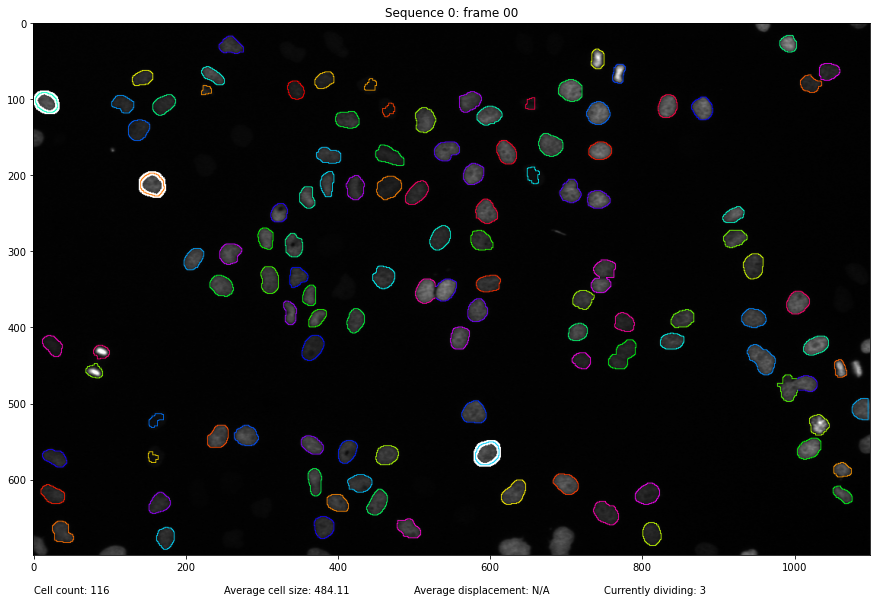

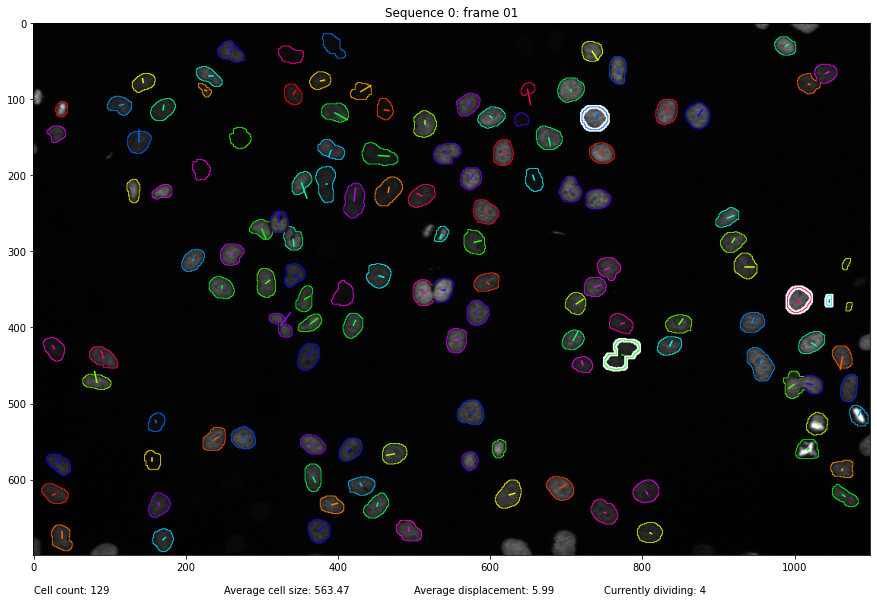

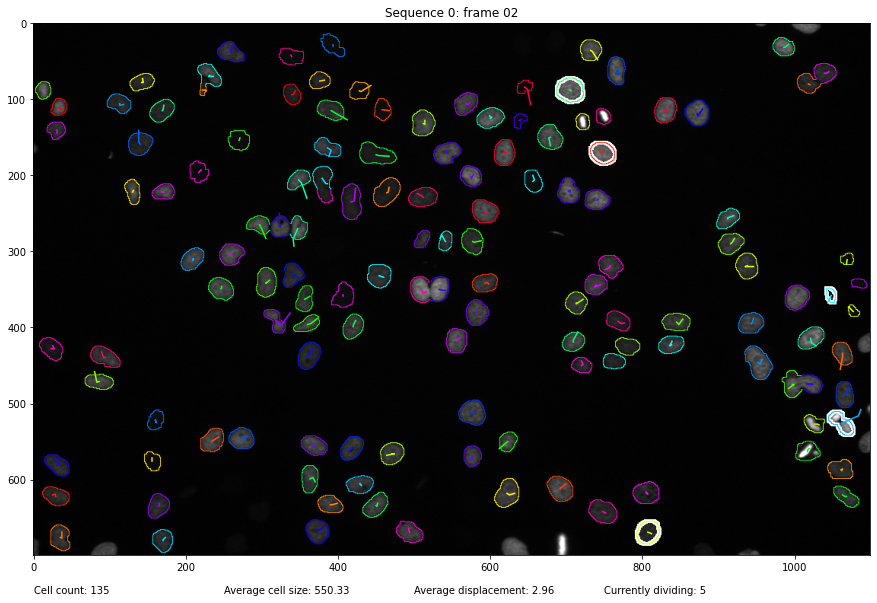

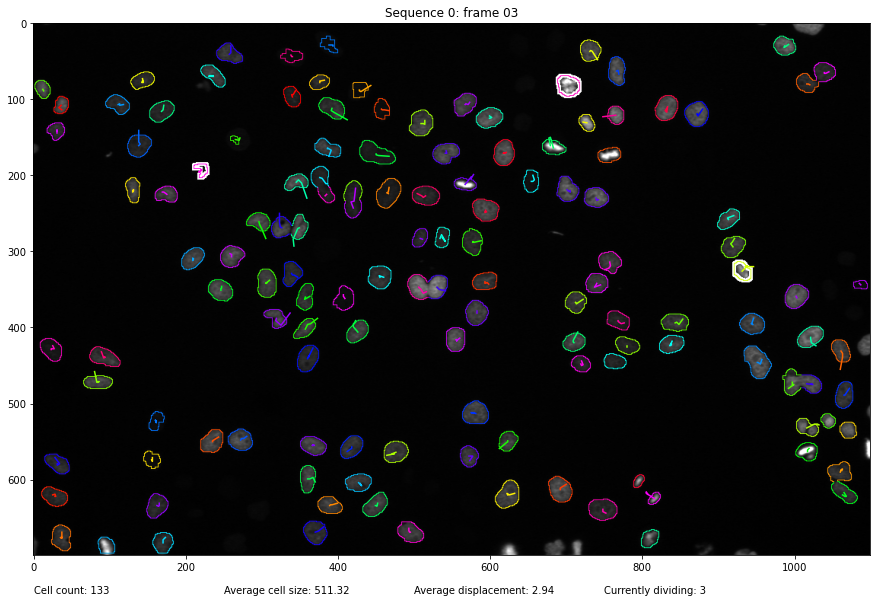

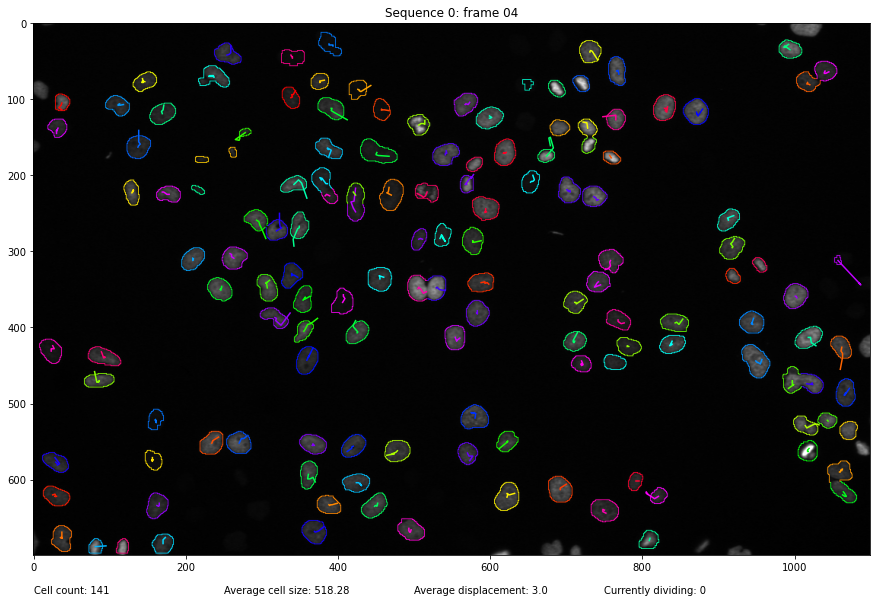

In [151]:
traj, paths, cents, split = nearest_neighbour(subset, show_img=True, seq_num=0, flushed_pts=flushed_subset, imgs=imgs[1])

In [97]:
already = []
dupes = 0
for label in cents[3].values():
#for label in centroids(seq[0][5]).values():
    if label in already:
        dupes+=1
    else:
        already.append(label)
print(dupes)

4


In [ ]:
traj, paths, cents, _ = nearest_neighbour(seq[0], seq_num=0, flushed_pts=flushed_seq[0], imgs=imgs[0])

In [12]:
dist_mat, rows, cols = distance_matrix(centroids(seq[0][16]), centroids(seq[0][17]))

In [36]:
(570,161) in seq[0][17].keys()

True

In [42]:
(570,161) in rows.values()

True

In [43]:
(570,161) in cols.values()

False

In [46]:
(570,161) in seq[0][18].keys()

True

In [47]:
(570,161) in seq[0][19].keys()

True

In [39]:
(570,161) in seq[0][16].keys()

False

In [50]:
cents = centroids(seq[0][16])

In [52]:
(570, 161) in cents.keys()

True